# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which already learned patterns on similar data to ours. Then we can adapt those patterns to our data.

## Becoming one with the data.

In [88]:
# !tar -xf "./data/05_transfer_learning_part1_feature_extraction/10_food_classes_10_percent.zip" -C "./data/05_transfer_learning_part1_feature_extraction/"

In [89]:
# print folder structure of unzipped data
import os
def print_dir(path:str, indents=0):
    indent = "    "
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            print(f"{indent*indents}{dir_name} - {len(os.listdir(dir_path))} items")
            print_dir(dir_path, indents+1)

In [90]:
print_dir("./data/05_transfer_learning_part1_feature_extraction/10_food_classes_10_percent/")

test - 10 items
    chicken_curry - 250 items
    chicken_wings - 250 items
    fried_rice - 250 items
    grilled_salmon - 250 items
    hamburger - 250 items
    ice_cream - 250 items
    pizza - 250 items
    ramen - 250 items
    steak - 250 items
    sushi - 250 items
train - 10 items
    chicken_curry - 75 items
    chicken_wings - 75 items
    fried_rice - 75 items
    grilled_salmon - 75 items
    hamburger - 75 items
    ice_cream - 75 items
    pizza - 75 items
    ramen - 75 items
    steak - 75 items
    sushi - 75 items


Looks like we have test and train sets already. There are 10 classes. Each class in test set have 250 samples and class in train set have 75 samples.

In [91]:
# print 5 items from class folder
os.listdir(
"./data/05_transfer_learning_part1_feature_extraction/10_food_classes_10_percent/train/chicken_curry/")[:5]

['1071242.jpg', '1140085.jpg', '116147.jpg', '1173563.jpg', '1179201.jpg']

Samples are images in jpg format.

In [92]:
## Create data batches
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)

train_patch = "./data/05_transfer_learning_part1_feature_extraction/10_food_classes_10_percent/train"
test_patch = "./data/05_transfer_learning_part1_feature_extraction/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=(1./255))
test_datagen = ImageDataGenerator(rescale=(1./255))

train_batch = train_datagen.flow_from_directory(train_patch, 
                                               target_size=IMAGE_SHAPE,
                                                seed=42)            

test_batch = test_datagen.flow_from_directory(test_patch, 
                                               target_size=IMAGE_SHAPE,
                                                seed=42)    

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [93]:
# Create TensorBoard callback
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = (dir_name + "/" +
              experiment_name + "/" +
              datetime.datetime.utcnow().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
    return tensorboard_callback

## Creating models using TensorFlow Hub

In [94]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [95]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Sequential, layers


In [96]:
# function that creates models from tfhub
def create_model(model_url, num_classes=10):
    # Download the pretrained model and save it as a keras layer
    feat_exctr_layer = hub.KerasLayer(model_url,
                                      trainable=False,  # freeze the already learned patterns
                                     name="feat_exctr_layer",
                                     input_shape=IMAGE_SHAPE+(3,),
                                     dtype=tf.float32) 
    
    # Create model
    model = Sequential([
        feat_exctr_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer", dtype=tf.float32)
    ])
    
    return model

### Creating and testing ResNet

In [97]:
# create a model
resnet = create_model(resnet_url, 10)

In [98]:
# Compile a model
resnet.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [99]:
# fit the model
resnet_history = resnet.fit(train_batch, 
          steps_per_epoch=len(train_batch),
          epochs=5,
          validation_data=test_batch,
          validation_steps=len(test_batch),
          callbacks=[create_tensorboard_callback("logs/05_transfer_learning_part1_feature_extraction",
                                                "resnet50V2")])

Epoch 1/5
24/24 [==============================] - 21s 684ms/step - loss: 1.8763 - accuracy: 0.3773 - val_loss: 1.1755 - val_accuracy: 0.6456
Epoch 2/5
24/24 [==============================] - 14s 584ms/step - loss: 0.8898 - accuracy: 0.7293 - val_loss: 0.8327 - val_accuracy: 0.7388
Epoch 3/5
24/24 [==============================] - 15s 624ms/step - loss: 0.6125 - accuracy: 0.8240 - val_loss: 0.7447 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 14s 600ms/step - loss: 0.4723 - accuracy: 0.8827 - val_loss: 0.6997 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 14s 583ms/step - loss: 0.3865 - accuracy: 0.9080 - val_loss: 0.6784 - val_accuracy: 0.7732


This models outperform models from prevoius notebook on smaller dataset and way faster.

In [100]:
# Let's create a function to plot our loss curves
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def plot_loss_curves(models_history):
    df = pd.DataFrame(models_history.history)
    df_acc = df.filter(["accuracy", "val_accuracy"], axis=1)
    df_acc.plot()
    plt.title("Accuracy vs val_accurcy", c="white", size=15)
    plt.xlabel("epochs", c="white",size=15)
    plt.ylabel("Accuracy", c="white", size=15)
    
    df_loss = df.filter(["loss", "val_loss"], axis=1)
    df_loss.plot()
    plt.title("loss vs val_loss", c="white", size=15)
    plt.xlabel("epochs", c="white", size=15)
    plt.ylabel("Loss", c="white", size=15)

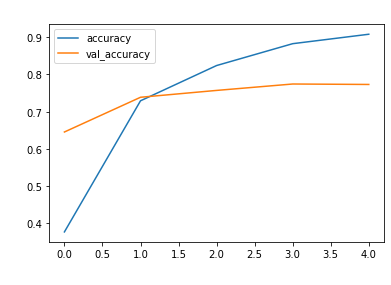

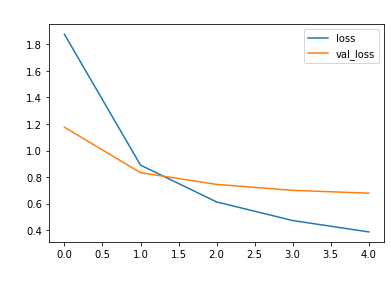

In [101]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0

In [102]:
# create a model
effnet = create_model(effnet_url, 10)

In [103]:
# compile a model
effnet.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [104]:
effnet_history = effnet.fit(train_batch,
    steps_per_epoch=len(train_batch),
    validation_data=test_batch,
    validation_steps=len(test_batch),
    epochs=5,
    callbacks=[create_tensorboard_callback("logs/05_transfer_learning_part1_feature_extraction",
                                           "efficientnetB0")])
                        

Epoch 1/5
24/24 [==============================] - 32s 845ms/step - loss: 1.7999 - accuracy: 0.4787 - val_loss: 1.2500 - val_accuracy: 0.7540
Epoch 2/5
24/24 [==============================] - 14s 614ms/step - loss: 1.0271 - accuracy: 0.7987 - val_loss: 0.8418 - val_accuracy: 0.8268
Epoch 3/5
24/24 [==============================] - 14s 606ms/step - loss: 0.7395 - accuracy: 0.8467 - val_loss: 0.6797 - val_accuracy: 0.8484
Epoch 4/5
24/24 [==============================] - 15s 628ms/step - loss: 0.5934 - accuracy: 0.8747 - val_loss: 0.5969 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 14s 611ms/step - loss: 0.5025 - accuracy: 0.8880 - val_loss: 0.5480 - val_accuracy: 0.8608


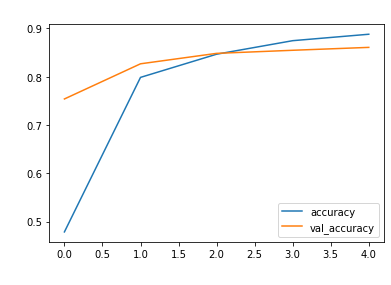

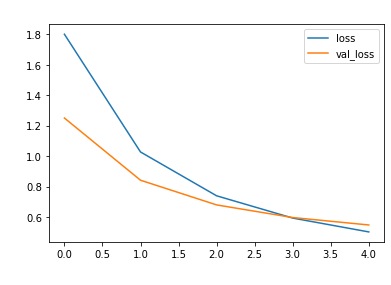

In [105]:
plot_loss_curves(effnet_history)

## Types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes
* **"Feature extraction"** - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* **"Fine-tuning"** - use the prelearned patterns of an existing model and "tiny-tune" many of all os the underlying layers (including new output layers)

## TensorBoard

In [110]:
%tensorboard --logdir ./logs/05_transfer_learning_part1_feature_extraction/
